# XGBoost mit Hyperparameter für jede Automarke

Der Zweck dieses Abschnitts besteht darin, die XGBoost-Modelle für jede Automarke mit den bereits im vorherigen Notizbuch gefundenen Hyperparametern zu trainieren, um sie als Modell-Dateien für die Verwendung in Streamlit vorzubereiten.

# Vorbereitung des besten Modells KomboGradientBoostingLog (Klasse definieren)

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

# Setzen Sie die Option, um alle Spalten anzuzeigen
pd.set_option('display.max_columns', None)

# # Daten einlesen (Beispiel-Pfad)
cars = pd.read_csv("Cars_Data_Model.csv", sep=";", index_col=0)

# # Ausreißer entfernen
cars = cars[cars["Preis"] < 300000]

# Aufteilung der Daten in Marken-DataFrames
audi = cars[cars["Marke_audi"] == 1]
bmw = cars[cars["Marke_bmw"] == 1]
mercedes = cars[cars["Marke_mercedes-benz"] == 1]
opel = cars[cars["Marke_opel"] == 1]
porsche = cars[cars["Marke_porsche"] == 1]
volkswagen = cars[cars["Marke_volkswagen"] == 1]

# Initialisieren des Skalierers
scaler = RobustScaler()

# Dictionary zum Speichern der Trainings-, Test- und Validierungssets für jede Marke
brand_datasets = {}

# Eine Liste der Marken und ihrer entsprechenden DataFrames erstellen
brand_dataframes = {
    'audi': audi,
    'bmw': bmw,
    'mercedes-benz': mercedes,
    'opel': opel,
    'porsche': porsche,
    'volkswagen': volkswagen
}

# Für jede Marke die Daten aufteilen und skalieren
for brand, df in brand_dataframes.items():
    X_brand = df.drop("Preis", axis=1)
    y_brand = np.log(df["Preis"])  # Logarithmische Transformation

    # Daten aufteilen
    X_train, X_rest, y_train, y_rest = train_test_split(X_brand, y_brand, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

    # Features skalieren
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # In das Dictionary speichern
    brand_datasets[brand] = {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }


Die Herleitung der optimalen Hyperparameter für jede Marke ist im File XGBoost_per_company_class.ipynb zu finden

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

class KomboGradientBoostingLog:
    def __init__(self):
        self.models = {
            'audi': GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1),
            'volkswagen': GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.2),
            'porsche': GradientBoostingRegressor(n_estimators=100, max_depth=7, learning_rate=0.2),
            'opel': GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1),
            'mercedes-benz': GradientBoostingRegressor(n_estimators=300, max_depth=7, learning_rate=0.1),
            'bmw': GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
        }

    def fit(self, brand_datasets):
        for brand, datasets in brand_datasets.items():
            if brand in self.models:
                self.models[brand].fit(datasets['X_train'], datasets['y_train'])

    def predict(self, X):
        predictions = pd.Series(index=X.index)

        # Verarbeiten Sie jede Marke einzeln und überprüfen Sie, ob Daten vorhanden sind
        for brand in ['audi', 'volkswagen', 'bmw', 'mercedes-benz', 'opel', 'porsche']:
            brand_column = f'Marke_{brand}'
            if brand_column in X.columns and not X[X[brand_column] == 1].empty:
                predictions[X[brand_column] == 1] = self.models[brand].predict(X[X[brand_column] == 1])

        return predictions


In [ ]:
# Erstellen Sie die Instanz der Klasse
kombo_model = KomboGradientBoostingLog()

# Trainieren Sie die Modelle mit den vorbereiteten Daten
kombo_model.fit(brand_datasets)

# Vorhersagen für Trainings-, Validierungs- und Testdatensätze
y_train_pred_kgbl = kombo_model.predict(X_train_scaled)
y_val_pred_kgbl = kombo_model.predict(X_val_scaled)
y_test_pred_kgbl = kombo_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Initialisieren der Metrik-Listen für jedes Set
rmse_train_list, rmse_val_list, rmse_test_list = [], [], []
mape_train_list, mape_val_list, mape_test_list = [], [], []
mae_train_list, mae_val_list, mae_test_list = [], [], []
r2_train_list, r2_val_list, r2_test_list = [], [], []

# Berechnen der Metriken für jede Marke separat
for brand, datasets in brand_datasets.items():
    # Vorhersagen für jedes Set
    y_pred_train = kombo_model.models[brand].predict(datasets['X_train'])
    y_pred_val = kombo_model.models[brand].predict(datasets['X_val'])
    y_pred_test = kombo_model.models[brand].predict(datasets['X_test'])

    # Berechnen und Speichern der Metriken für jedes Set
    rmse_train_list.append(mean_squared_error(np.exp(datasets['y_train']), np.exp(y_pred_train), squared=False))
    rmse_val_list.append(mean_squared_error(np.exp(datasets['y_val']), np.exp(y_pred_val), squared=False))
    rmse_test_list.append(mean_squared_error(np.exp(datasets['y_test']), np.exp(y_pred_test), squared=False))

    mape_train_list.append(mean_absolute_percentage_error(np.exp(datasets['y_train']), np.exp(y_pred_train)))
    mape_val_list.append(mean_absolute_percentage_error(np.exp(datasets['y_val']), np.exp(y_pred_val)))
    mape_test_list.append(mean_absolute_percentage_error(np.exp(datasets['y_test']), np.exp(y_pred_test)))

    mae_train_list.append(mean_absolute_error(np.exp(datasets['y_train']), np.exp(y_pred_train)))
    mae_val_list.append(mean_absolute_error(np.exp(datasets['y_val']), np.exp(y_pred_val)))
    mae_test_list.append(mean_absolute_error(np.exp(datasets['y_test']), np.exp(y_pred_test)))

    r2_train_list.append(r2_score(np.exp(datasets['y_train']), np.exp(y_pred_train)))
    r2_val_list.append(r2_score(np.exp(datasets['y_val']), np.exp(y_pred_val)))
    r2_test_list.append(r2_score(np.exp(datasets['y_test']), np.exp(y_pred_test)))

# Aggregieren der Metriken für jedes Set
rmse_avg_train, rmse_avg_val, rmse_avg_test = np.mean(rmse_train_list), np.mean(rmse_val_list), np.mean(rmse_test_list)
mape_avg_train, mape_avg_val, mape_avg_test = np.mean(mape_train_list), np.mean(mape_val_list), np.mean(mape_test_list)
mae_avg_train, mae_avg_val, mae_avg_test = np.mean(mae_train_list), np.mean(mae_val_list), np.mean(mae_test_list)
r2_avg_train, r2_avg_val, r2_avg_test = np.mean(r2_train_list), np.mean(r2_val_list), np.mean(r2_test_list)

# Ergebnisse ausgeben
print(f"RMSE Train: {rmse_avg_train}, Val: {rmse_avg_val}, Test: {rmse_avg_test}")
print(f"MAPE Train: {mape_avg_train}, Val: {mape_avg_val}, Test: {mape_avg_test}")
print(f"MAE Train: {mae_avg_train}, Val: {mae_avg_val}, Test: {mae_avg_test}")
print(f"R^2 Train: {r2_avg_train}, Val: {r2_avg_val}, Test: {r2_avg_test}")


RMSE Train: 3245.443821861982, Val: 7576.675649713866, Test: 7781.267997829927
MAPE Train: 0.06890607938966471, Val: 0.12128657638095858, Test: 0.1265090272584851
MAE Train: 2086.4275143101972, Val: 3937.195006313225, Test: 4012.0150687295004
R^2 Train: 0.9794345445803275, Val: 0.9191033293570062, Test: 0.9193551817611662


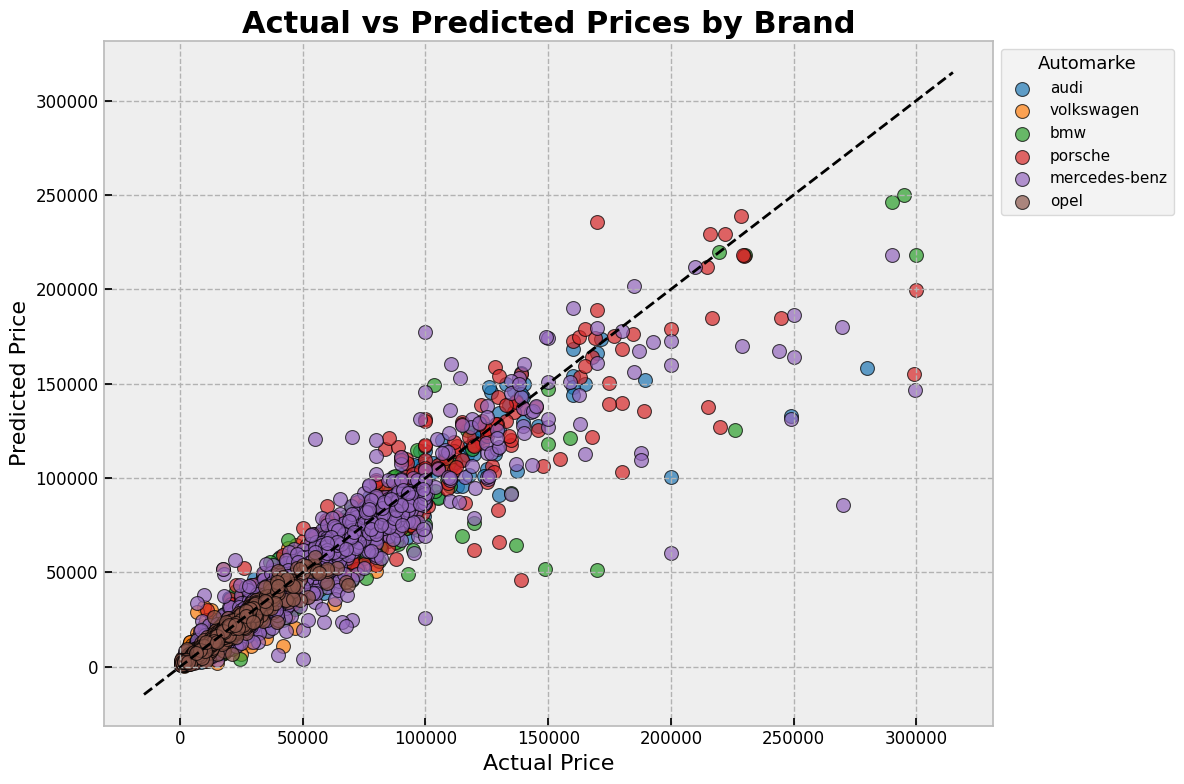

In [ ]:
def plot_brand_predictions(brand_datasets, model):
    plt.style.use('bmh')
    sns.set_context('notebook')
    fig, ax = plt.subplots(figsize=(12, 8))
    brands = ['audi', 'volkswagen', 'bmw', 'porsche', 'mercedes-benz', 'opel']
    colors = sns.color_palette('tab10', n_colors=len(brands))

    for i, brand in enumerate(brands):
        # Überprüfen, ob die Marke in brand_datasets vorhanden ist
        if brand in brand_datasets:
            datasets = brand_datasets[brand]
            X_test_scaled = datasets['X_test']
            y_test = datasets['y_test']

            # Vorhersagen für die Marke treffen
            y_test_pred = model.models[brand].predict(X_test_scaled)

            # Umkehrung der Logarithmustransformation
            y_test_original = np.exp(y_test)
            y_test_pred_original = np.exp(y_test_pred)

            # Plot für die Marke
            sns.scatterplot(x=y_test_original, y=y_test_pred_original, color=colors[i], label=brand, ax=ax, s=100, alpha=0.7, edgecolor='black')

    # Linie der perfekten Übereinstimmung
    line_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    line_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    sns.lineplot(x=[line_min, line_max], y=[line_min, line_max], color='black', ax=ax, linewidth=2, linestyle='--')

    ax.set_title('Actual vs Predicted Prices by Brand', fontsize=22, fontweight='bold')
    ax.set_xlabel('Actual Price', fontsize=16)
    ax.set_ylabel('Predicted Price', fontsize=16)
    # Anpassen der Legende
    ax.legend(title='Automarke', title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, framealpha=0.7)    # Formatierung der Ticks

    # Anpassen der Tick-Parameter
    ax.tick_params(axis='both', which='major', labelsize=12, color='black')
    plt.tight_layout()
    plt.show()

# Aufrufen der Plot-Funktion
plot_brand_predictions(brand_datasets, kombo_model)


# Streamlit Model download (training on all data)

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

class KomboGradientBoostingLog:
    def __init__(self):
        self.audi = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
        self.vw = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.2)
        self.porsche = GradientBoostingRegressor(n_estimators=100, max_depth=7, learning_rate=0.2)
        self.opel = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
        self.mb = GradientBoostingRegressor(n_estimators=300, max_depth=7, learning_rate=0.1)
        self.bmw = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)

    def fit(self, X, y):
        # Split the Dataframe and fit models for each brand
        self.audi.fit(X[X["Marke_audi"] == 1], y[X["Marke_audi"] == 1])
        self.vw.fit(X[X["Marke_volkswagen"] == 1], y[X["Marke_volkswagen"] == 1])
        self.bmw.fit(X[X["Marke_bmw"] == 1], y[X["Marke_bmw"] == 1])
        self.porsche.fit(X[X["Marke_porsche"] == 1], y[X["Marke_porsche"] == 1])
        self.mb.fit(X[X["Marke_mercedes-benz"] == 1], y[X["Marke_mercedes-benz"] == 1])
        self.opel.fit(X[X["Marke_opel"] == 1], y[X["Marke_opel"] == 1])


    def predict(self, X):
      predictions = []

      brands = {
          'audi': self.audi,
          'volkswagen': self.vw,
          'bmw': self.bmw,
          'porsche': self.porsche,
          'mercedes-benz': self.mb,
          'opel': self.opel
      }

      for brand, model in brands.items():
          brand_data = X[X[f"Marke_{brand}"] == 1]
          if not brand_data.empty:
              brand_pred = pd.Series(model.predict(brand_data), index=brand_data.index)
              predictions.append(brand_pred)

      print(predictions)

      if predictions:
          y_all_pred = pd.concat(predictions).reindex(X.index)
          return y_all_pred
      else:
          # Rückgabe eines leeren DataFrame oder einer Fehlermeldung
          return pd.Series([], index=X.index)


In [70]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Cars_Data_Model.csv", sep=";", index_col=0)
cars = cars.copy()


# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars = cars[cars["Preis"] < 300000]


# Define X and y and drop features
X = cars.drop("Preis", axis=1)
y = cars.loc[:,"Preis"]

y = np.log(y)

# Data Scaling
scaler = RobustScaler()
scaler.fit(X)

# Scale the datasets and convert back to DataFrame
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)         ################################################### @ Dario neu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
KomboGradientBoostingLog_final = KomboGradientBoostingLog()

In [72]:
KomboGradientBoostingLog_final.fit(X_scaled, y)

In [44]:
X_scaled

,Kilometerstand,Fahrleistung p.a.,Türen,Komfort,Sicherheit,Extras,Erstzulassung,Unterhaltung/Media,Hubraum,Schadstoffklasse,Fahrzeugzustand,KW,PS,Marke_audi,Marke_bmw,Marke_mercedes-benz,Marke_opel,Marke_porsche,Marke_volkswagen,Modell_100,Modell_114,Modell_116,Modell_118,Modell_120,Modell_123,Modell_125,Modell_128,Modell_130,Modell_135,Modell_140,Modell_170,Modell_180,Modell_181,Modell_190,Modell_1er-m-coupé,Modell_200,Modell_2002,Modell_208,Modell_214,Modell_216,Modell_218,Modell_220,Modell_223,Modell_225,Modell_228,Modell_230,Modell_235,Modell_240,Modell_250,Modell_260,Modell_270,Modell_280,Modell_300,Modell_308,Modell_315,Modell_316,Modell_318,Modell_320,Modell_323,Modell_324,Modell_325,Modell_328,Modell_330,Modell_335,Modell_340,Modell_350,Modell_356,Modell_380,Modell_400,Modell_418,Modell_420,Modell_425,Modell_428,Modell_430,Modell_435,Modell_440,Modell_450,Modell_50,Modell_500,Modell_518,Modell_520,Modell_523,Modell_524,Modell_525,Modell_528,Modell_530,Modell_535,Modell_540,Modell_545,Modell_550,Modell_560,Modell_600,Modell_620,Modell_628,Modell_630,Modell_633,Modell_635,Modell_640,Modell_645,Modell_650,Modell_718,Modell_718-spyder,Modell_725,Modell_728,Modell_730,Modell_735,Modell_740,Modell_745,Modell_750,Modell_760,Modell_80,Modell_840,Modell_850,Modell_90,Modell_911,Modell_912,Modell_914,Modell_918,Modell_924,Modell_928,Modell_930,Modell_944,Modell_964,Modell_968,Modell_991,Modell_992,Modell_993,Modell_996,Modell_997,Modell_a-140,Modell_a-150,Modell_a-160,Modell_a-170,Modell_a-180,Modell_a-190,Modell_a-200,Modell_a-210,Modell_a-220,Modell_a-250,Modell_a-35-amg,Modell_a-45-amg,Modell_a1,Modell_a2,Modell_a3,Modell_a4,Modell_a4-allroad,Modell_a5,Modell_a6,Modell_a6-allroad,Modell_a7,Modell_a8,Modell_active-hybrid-3,Modell_active-hybrid-5,Modell_active-hybrid-7,Modell_adam,Modell_agila,Modell_allroad,Modell_amarok,Modell_amg-gt,Modell_ampera,Modell_antara,Modell_arteon,Modell_ascona,Modell_astra,Modell_atego,Modell_b-150,Modell_b-160,Modell_b-170,Modell_b-180,Modell_b-200,Modell_b-220,Modell_b-250,Modell_b-electric-drive,Modell_beetle,Modell_bora,Modell_boxster,Modell_buggy,Modell_bus,Modell_c-160,Modell_c-180,Modell_c-200,Modell_c-220,Modell_c-230,Modell_c-240,Modell_c-250,Modell_c-270,Modell_c-280,Modell_c-300,Modell_c-32-amg,Modell_c-320,Modell_c-350,Modell_c-400,Modell_c-43-amg,Modell_c-450,Modell_c-55-amg,Modell_c-63-amg,Modell_cabriolet,Modell_caddy,Modell_calibra,Modell_carrera-gt,Modell_cascada,Modell_cayenne,Modell_cayman,Modell_cc,Modell_ce-220,Modell_ce-230,Modell_ce-280,Modell_ce-300,Modell_citan,Modell_cl,Modell_cl-180,Modell_cl-200,Modell_cl-230,Modell_cl-320,Modell_cl-420,Modell_cl-500,Modell_cl-55-amg,Modell_cl-600,Modell_cl-63-amg,Modell_cl-65-amg,Modell_cla-180,Modell_cla-200,Modell_cla-220,Modell_cla-250,Modell_cla-35-amg,Modell_cla-45-amg,Modell_clc,Modell_cle,Modell_clk-200,Modell_clk-220,Modell_clk-230,Modell_clk-240,Modell_clk-270,Modell_clk-280,Modell_clk-320,Modell_clk-350,Modell_clk-430,Modell_clk-500,Modell_clk-55-amg,Modell_clk-63-amg,Modell_cls,Modell_cls-220,Modell_cls-250,Modell_cls-280,Modell_cls-300,Modell_cls-320,Modell_cls-350,Modell_cls-400,Modell_cls-450,Modell_cls-500,Modell_cls-53-amg,Modell_cls-55-amg,Modell_cls-63-amg,Modell_combo,Modell_combo-e,Modell_combo-e-life,Modell_combo-life,Modell_commodore,Modell_corrado,Modell_corsa,Modell_corsa-e,Modell_coupe,Modell_crafter,Modell_cross-golf,Modell_cross-touran,Modell_crossland,Modell_crossland-x,Modell_diplomat,Modell_e-200,Modell_e-220,Modell_e-230,Modell_e-240,Modell_e-250,Modell_e-260,Modell_e-270,Modell_e-280,Modell_e-290,Modell_e-300,Modell_e-320,Modell_e-350,Modell_e-36-amg,Modell_e-400,Modell_e-420,Modell_e-43-amg,Modell_e-430,Modell_e-450,Modell_e-50-amg,Modell_e-500,Modell_e-53-amg,Modell_e-55-amg,Modell_e-550,Modell_e-60-amg,Modell_e-63-amg,Modell_e-golf,Modell_e-tron,Modell_e-tron-gt,Modell_e-up!,Modell_eos,Modell_eqa,Modell_eqa-250,Modell_eqa-300,Modell_eqa-350,Modell_eqb-250,Modell_eqb-300,Modell_eqb-350,Modell_eqc-400,M

In [ ]:
# Save Model

In [47]:
# Save Model
import pickle
filename = 'KomboGradientBoostingLog_final2.sav'
pickle.dump(KomboGradientBoostingLog_final, open("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/" + filename, 'wb'))

In [48]:
# Save Scaler
import pickle
filename = 'Scaler_final2.sav'
pickle.dump(scaler, open("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/" + filename, 'wb'))